In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [ ]:
from einops import rearrange
import math
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from bliss.encoders.detection import DetectionEncoder
from bliss.catalog import TileCatalog, FullCatalog

import sep_pjw as sep

from bliss.datasets.lsst import BACKGROUND

from torch import Tensor

from bliss.reporting import compute_tp_fp_per_bin

In [ ]:
def asinh_map(x, q=0.01, stretch=1, minimum=0):
    return np.arcsinh(q * (x - minimum) / stretch) / q


def get_equally_spaced_bins(x:Tensor, n_bins=20):
    assert x.ndim == 1
    x = x[x > 0]
    x_sorted = x.sort()[0]
    
    starts = []
    ends = []
    for ii in range(n_bins):
        start = x_sorted.quantile(ii / n_bins)
        end = x_sorted.quantile((ii+1) / n_bins)

        starts.append(start.item())
        ends.append(end.item())

    return torch.tensor([starts, ends]).T



In [ ]:
device = torch.device("cuda:0")
TILE_SLEN = 4
PTILE_SLEN = 52
BP = 24

In [ ]:
# model
detection = DetectionEncoder().to(device).eval()
_ = detection.load_state_dict(
    torch.load(f"../../models/detection_42_42.pt", map_location=device, weights_only=True)
)
detection = detection.requires_grad_(False)

In [ ]:
# data
from bliss.datasets.io import load_dataset_npz

test_ds = load_dataset_npz("../../data/datasets/test_ds_42.npz")
test_ds.keys()

dict_keys(['images', 'noiseless', 'uncentered_sources', 'centered_sources', 'paddings', 'fluxes', 'star_bools', 'plocs', 'n_sources', 'galaxy_params', 'star_fluxes', 'galaxy_bools'])

In [ ]:
test_ds['paddings'].shape

torch.Size([10000, 1, 88, 88])

In [ ]:
# use 1000 images for now to speedup iteration time
test_ds_sample = {p: q[:2000] for p, q in test_ds.items()}
images = test_ds_sample["images"]
single_centered = test_ds_sample['centered_sources']
images.shape, single_centered.shape

(torch.Size([2000, 1, 88, 88]), torch.Size([2000, 10, 1, 88, 88]))

In [ ]:
# obtain outputs from all images
from bliss.render_tiles import make_ptile_loader

ptile_loader = make_ptile_loader(images, device)

In [ ]:
# process batches of images
nth = (images.shape[2] - 2 * BP) // TILE_SLEN
ntw = (images.shape[3] - 2 * BP) // TILE_SLEN
n1 = math.ceil(images.shape[0] / 10)
n2 = math.ceil(nth / 15)
total_n_ptiles = n1 * n2

tiled_params_list = []
for flat_ptiles in tqdm(ptile_loader, total=total_n_ptiles):

    n_source_probs, locs_mean, locs_sd_raw = detection.encode_tiled(flat_ptiles)

    _tiled_params = {
        "n_source_probs": n_source_probs.cpu(),
        "locs_mean": locs_mean.cpu(),
        "locs_sd": locs_sd_raw.cpu(),
    }
    tiled_params_list.append(_tiled_params)

  0%|          | 1/200 [00:00<01:30,  2.20it/s]

100%|██████████| 200/200 [00:06<00:00, 29.41it/s]


In [ ]:
from bliss.encoders.encoder import collate

tiled_params = collate(tiled_params_list)

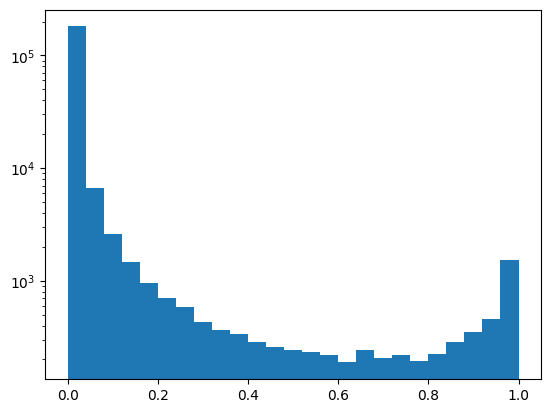

In [ ]:
plt.hist(tiled_params["n_source_probs"].cpu().numpy(), bins=25)
plt.yscale('log')

In [ ]:
# get full catalogs for different thresholds
thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
pred_cats = {}

for thres in thresholds:
    n_source_probs = tiled_params["n_source_probs"]
    n_sources = n_source_probs.ge(thres).long()
    tiled_is_on = rearrange(n_source_probs.ge(thres).float(), "n -> n 1")

    locs = tiled_params["locs_mean"] * tiled_is_on
    locs_sd = tiled_params["locs_sd"] * tiled_is_on

    tile_cat = TileCatalog.from_flat_dict(
        TILE_SLEN,
        nth,
        ntw,
        {
            "n_sources": n_sources,
            "locs": locs,
            "locs_sd": locs_sd,
            "n_source_probs": n_source_probs.reshape(-1, 1),
        },
    )

    pred_cats[thres] = tile_cat.to_full_params()

In [ ]:
pred_cats[0.1]['n_source_probs'].shape

torch.Size([2000, 22, 1])

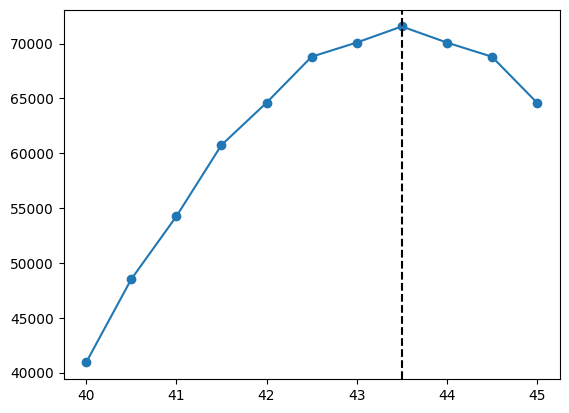

In [ ]:
# check we should calculate centroid as 43.5 given the size of our images
xs = np.arange(40, 45.5, 0.5)
flux, fluxerr, flag = sep.sum_circle(single_centered[0,0,0].numpy(), xs, xs, 5.0, err=BACKGROUND.sqrt())
plt.plot(xs, flux, '-o')
plt.axvline(43.5, color='k', linestyle='--')

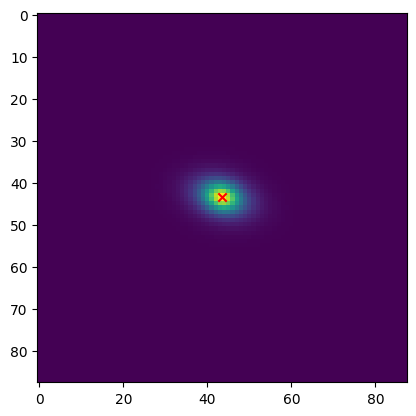

In [ ]:
# same as true image center in matplotlib
plt.scatter(43.5, 43.5, marker='x', color='r')
plt.imshow(single_centered[0, 0, 0])

In [ ]:
# get true SNR
snrs = torch.zeros_like(test_ds_sample['fluxes'])
n_batches = test_ds_sample['n_sources'].shape[0]
for ii in range(n_batches):
    n_sources =  test_ds_sample['n_sources'][ii].item()
    for jj in range(n_sources):
        image = single_centered[ii, jj, 0, :, :].numpy()
        flux, fluxerr, _ = sep.sum_circle(image, [43.5], [43.5], 5.0, err=BACKGROUND.sqrt())
        snrs[ii, jj, 0] = flux.item() / fluxerr.item()

test_ds_sample['snr'] = snrs

In [ ]:
# # compare with flux to make sure aligned
# test_ds_sample['snr'][150], test_ds_sample['fluxes'][150]

In [ ]:
# get truth catalog
# TODO: For other results we exclude from comparisons when multiple sources fall into one tile
# ok to include this here? 


exclude = ("images", "uncentered_sources", "centered_sources", "noiseless", "paddings")
slen = images.shape[-1] - 2 * BP
true_cat_dict = {p: q for p, q in test_ds_sample.items() if p not in exclude}
truth = FullCatalog(slen, slen, true_cat_dict)

In [ ]:
# get estimated SNR with aperture photometry on target images 

for _, cat in pred_cats.items():
    n_batches = cat.n_sources.shape[0]
    snrs = torch.zeros((n_batches, cat.max_n_sources, 1))
    for ii in range(n_batches):
        n_sources = cat.n_sources[ii].item()
        _plocs = cat.plocs[ii]
        y = _plocs[:, 0].numpy() + BP - 0.5
        x = _plocs[:, 1].numpy() + BP - 0.5
        flux, fluxerr, _ = sep.sum_circle(images[ii, 0].numpy(), x, y, 5.0, err=BACKGROUND.sqrt().item())
        snrs[ii, :n_sources, 0] = torch.from_numpy(flux / fluxerr)[:n_sources]
    cat['snr'] = snrs.clip(min=0)

In [ ]:
# now we need to obtain a full catalog with SEP to obtain the corresponding curve
max_n_sources = 0
all_params = []


for ii in range(images.shape[0]):
    im = images[ii, 0].numpy()
    bkg = sep.Background(im)
    catalog = sep.extract(im, 1.5, err=bkg.globalrms, minarea=5)

    x1 = catalog['x']
    y1 = catalog['y']

    # need to ignore detected sources that are in the padding
    in_padding = (x1 < 23.5) | (x1 > 63.5) | (y1 < 23.5) | (y1 > 63.5)

    x = x1[np.logical_not(in_padding)]
    y = y1[np.logical_not(in_padding)]

    n = len(x)
    max_n_sources = max(n, max_n_sources)

    all_params.append((n, x, y))

n_sources = torch.zeros((images.shape[0],)).long()
plocs = torch.zeros((images.shape[0], max_n_sources, 2))

for jj in range(images.shape[0]):
    n, x, y = all_params[jj]
    n_sources[jj] = n

    plocs[jj, :n, 0] = torch.from_numpy(y) - BP + 0.5
    plocs[jj, :n, 1] = torch.from_numpy(x) - BP + 0.5

sep_cat = FullCatalog(slen, slen, {'n_sources':n_sources, 'plocs':plocs})

In [ ]:
# now we compute snr for sep_cat
n_batches = sep_cat.n_sources.shape[0]
snrs = torch.zeros((n_batches, sep_cat.max_n_sources, 1))
for ii in range(n_batches):
    n = sep_cat.n_sources[ii].item()
    _plocs = sep_cat.plocs[ii]
    y = _plocs[:, 0].numpy() + BP - 0.5
    x = _plocs[:, 1].numpy() + BP - 0.5
    flux, fluxerr, _ = sep.sum_circle(images[ii, 0].numpy(), x, y, 5.0, err=BACKGROUND.sqrt().item())
    snrs[ii, :n, 0] = torch.from_numpy(flux / fluxerr)[:n]
sep_cat['snr'] = snrs.clip(min=0)

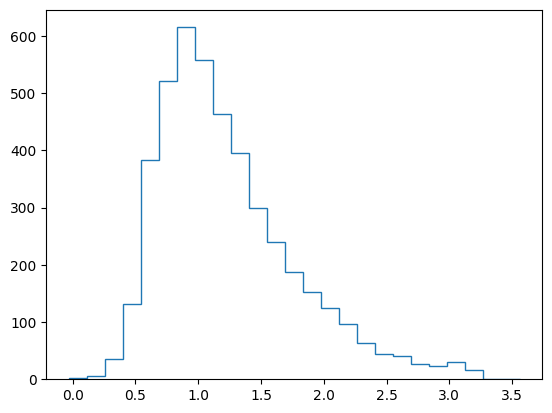

In [ ]:
snrs = pred_cats[0.5]['snr'].ravel()
_snrs = snrs[snrs > 0 ]
_, bins, _ = plt.hist(_snrs.log10(), histtype='step', bins=25)

In [ ]:
# evenly space in logspace
snr_bins1 = 10 ** torch.arange(0, 3.0, 0.2)
snr_bins2 = 10 ** torch.arange(0.2, 3.2, 0.2)
snr_bins = torch.column_stack((snr_bins1, snr_bins2))
snr_bins.shape

torch.Size([15, 2])

In [ ]:
# # up to certain value

# snr_bins2 = 10 ** torch.arange(0.2, 3.2, 0.2)
# snr_bins1 = torch.full_like(snr_bins2, 0)
# snr_bins = torch.column_stack((snr_bins1, snr_bins2))
# snr_bins.shape

In [ ]:
# now compute for each threshold and plot f1 curves
thresh_out = {thresh:{} for thresh in pred_cats}
for tsh, cat in pred_cats.items():
    counts_per_bin = compute_tp_fp_per_bin(truth, cat, 'snr', snr_bins)

    precision = counts_per_bin['tp_precision'].sum(axis=-1) / (counts_per_bin['tp_precision'] + counts_per_bin['fp_precision']).sum(axis=-1)
    recall = counts_per_bin['tp_recall'].sum(axis=-1) / counts_per_bin['ntrue'].sum(axis=-1)
    f1 = 2 / (recall**-1 + precision**-1)


    thresh_out[tsh]['recall'] = recall
    thresh_out[tsh]['precision'] = precision
    thresh_out[tsh]['f1'] = f1

tp/fp per bin:   0%|          | 0/15 [00:00<?, ?it/s]

tp/fp per bin: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


In [ ]:
# sep results
counts_per_bin = compute_tp_fp_per_bin(truth, sep_cat, 'snr', snr_bins)

precision_sep = counts_per_bin['tp_precision'].sum(axis=-1) / (counts_per_bin['tp_precision'] + counts_per_bin['fp_precision']).sum(axis=-1)
recall_sep = counts_per_bin['tp_recall'].sum(axis=-1) / counts_per_bin['ntrue'].sum(axis=-1)
f1_sep =  2 / (recall_sep**-1 + precision_sep**-1)

tp/fp per bin:  20%|██        | 3/15 [00:00<00:03,  3.49it/s]

tp/fp per bin: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Text(0, 0.5, 'precision')

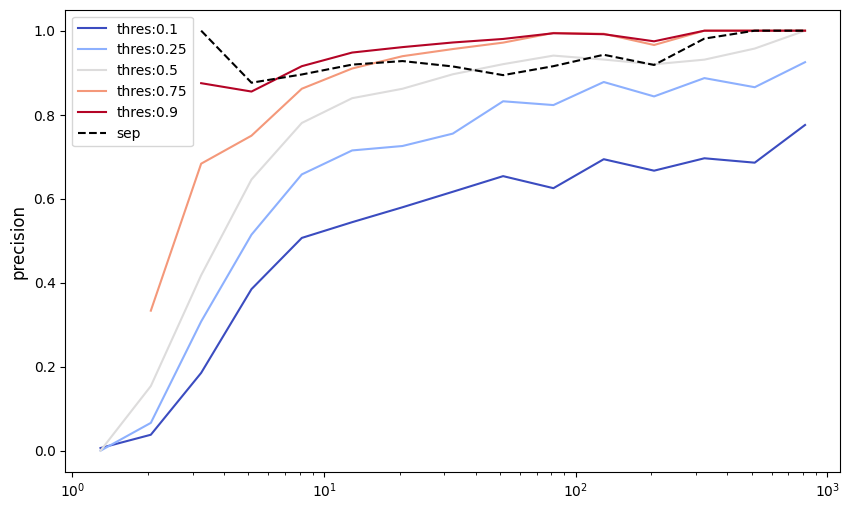

In [ ]:
import cycler

snr_middle = snr_bins.mean(axis=-1)
# snr_middle = snr_bins[:, 1]

color = plt.cm.coolwarm(np.linspace(0, 1, len(thresholds)))
cycles = cycler.cycler("color", color)
ax.set_prop_cycle(cycles)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for tsh in thresholds:
    ax.plot(snr_middle, thresh_out[tsh]['precision'], '-', label=f'thres:{tsh}')


ax.plot(snr_middle, precision_sep, '--k', label='sep')
ax.set_xscale('log')
ax.legend()

ax.set_ylabel("precision", fontsize=12)

Text(0, 0.5, 'recall')

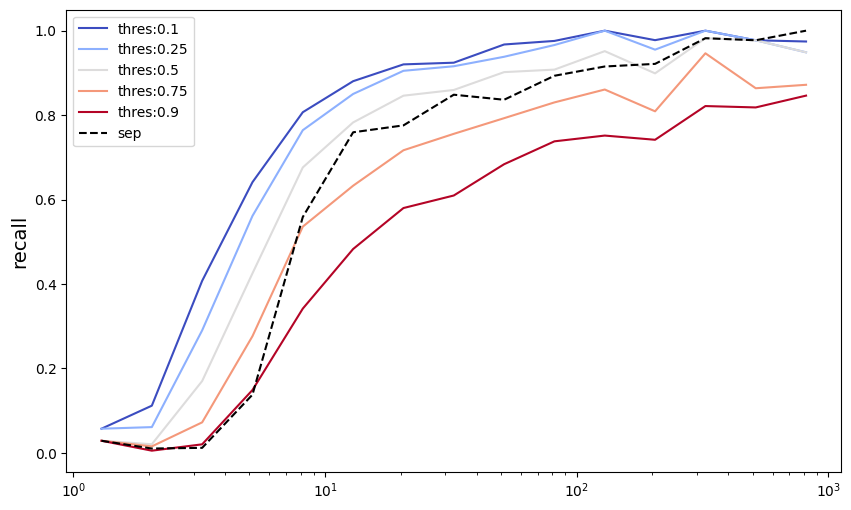

In [ ]:
import cycler

snr_middle = snr_bins.mean(axis=-1)

color = plt.cm.coolwarm(np.linspace(0, 1, len(thresholds)))
cycles = cycler.cycler("color", color)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_prop_cycle(cycles)

for tsh in thresholds:
    ax.plot(snr_middle, thresh_out[tsh]['recall'], '-', label=f'thres:{tsh}')


ax.plot(snr_middle, recall_sep, '--k', label='sep')
ax.legend()

ax.set_xscale('log')

ax.set_ylabel("recall", fontsize=14)

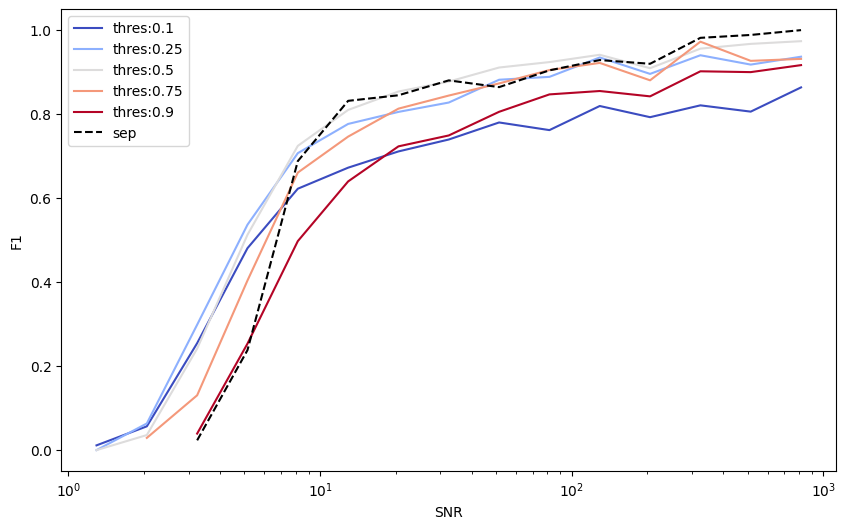

In [ ]:
import cycler

snr_middle = snr_bins.mean(axis=-1)

color = plt.cm.coolwarm(np.linspace(0, 1, len(thresholds)))
cycles = cycler.cycler("color", color)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_prop_cycle(cycles)

for tsh in thresholds:
    ax.plot(snr_middle, thresh_out[tsh]['f1'], '-', label=f'thres:{tsh}')


ax.plot(snr_middle, f1_sep, '--k', label='sep')
ax.legend()
ax.set_ylabel("F1")
ax.set_xlabel("SNR")

ax.set_xscale('log')

## Images for comparison

In [ ]:
# let's compare some images
idx = 330
idx2 = 2
x = images[idx, 0].numpy()
_image = asinh_map(x, q=0.01, stretch=1)

# sep 
bkg = sep.Background(x)
catalog = sep.extract(x, 1.5, err=bkg.globalrms, minarea=5)


n1 = truth.n_sources[idx].item()
n2 = pred_cats[idx2].n_sources[idx].item()

x1 = truth.plocs[idx, :, 1] - 0.5 + BP
y1 = truth.plocs[idx, :, 0] - 0.5 + BP

x2 = pred_cats[idx2].plocs[idx, :, 1] - 0.5 + BP
y2 = pred_cats[idx2].plocs[idx, :, 0] - 0.5 + BP

plt.imshow(_image)

for ii in range(n1):
    plt.scatter(x1[ii], y1[ii], marker="x", color="r")

for ii in range(n2):
    plt.scatter(x2[ii], y2[ii], marker="+", color="b")

plt.scatter(catalog['x'], catalog['y'], marker='o', color='m', facecolors='none')



KeyError: 2

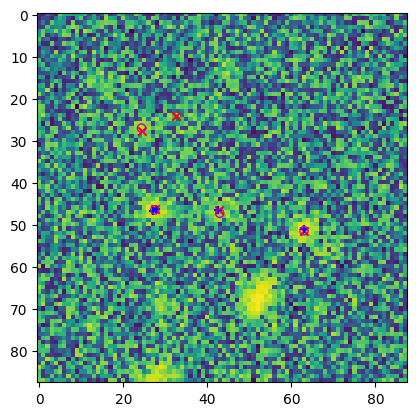

In [ ]:
# check sep full catalog is correc 
idx = 330
idx2 = 2
x = images[idx, 0].numpy()
_image = asinh_map(x, q=0.01, stretch=1)


n1 = truth.n_sources[idx].item()
n2 = pred_cats[idx2].n_sources[idx].item()
n3 = sep_cat.n_sources[idx].item()

x1 = truth.plocs[idx, :, 1] - 0.5 + BP
y1 = truth.plocs[idx, :, 0] - 0.5 + BP

x2 = pred_cats[idx2].plocs[idx, :, 1] - 0.5 + BP
y2 = pred_cats[idx2].plocs[idx, :, 0] - 0.5 + BP

x3 = sep_cat.plocs[idx, :, 1] - 0.5 + BP
y3 = sep_cat.plocs[idx, :, 0] - 0.5 + BP

plt.imshow(_image)

for ii in range(n1):
    plt.scatter(x1[ii], y1[ii], marker="x", color="r")

for ii in range(n2):
    plt.scatter(x2[ii], y2[ii], marker="+", color="b")

for ii in range(n2):
    plt.scatter(x3[ii], y3[ii], marker="o", color="m", facecolors='none')

# plt.scatter(catalog['x'], catalog['y'], marker='o', color='m', facecolors='none')



## Test probabilty weighted curves

In [ ]:
from bliss.reporting import match_by_locs

def compute_batch_tp_fp_prob(truth: FullCatalog, est: FullCatalog):
    """Separate purpose from `DetectionMetrics`, since here we don't aggregate over batches."""
    all_tp = torch.zeros(truth.batch_size)
    all_fp = torch.zeros(truth.batch_size)
    all_ntrue = torch.zeros(truth.batch_size)
    for b in range(truth.batch_size):
        ntrue = truth.n_sources[b].int().item()
        nest = est.n_sources[b].int().item()
        tlocs, elocs = truth.plocs[b], est.plocs[b]
        probs = est['n_source_probs'][b, :, 0]
        if ntrue > 0 and nest > 0:
            _, mest, dkeep, _ = match_by_locs(tlocs, elocs)
            tp = sum(probs[mest][dkeep])
            fp = sum(probs) - tp
        elif ntrue > 0:
            tp = 0
            fp = 0
        elif nest > 0:
            tp = 0
            fp = sum(probs)
        else:
            tp = 0
            fp = 0
        all_tp[b] = tp
        all_fp[b] = fp
        all_ntrue[b] = ntrue

    return all_tp, all_fp, all_ntrue


from collections import defaultdict
def compute_tp_fp_per_bin_prob(
    truth: FullCatalog,
    est: FullCatalog,
    param: str,
    bins: Tensor,):
    counts_per_bin = defaultdict(
        lambda: torch.zeros(len(bins), truth.batch_size)
    )
    for ii, (b1, b2) in tqdm(enumerate(bins), desc="tp/fp per bin", total=len(bins)):
        # precision
        eparams = est.apply_param_bin(param, b1, b2)
        tp, fp, _ = compute_batch_tp_fp_prob(truth, eparams)
        counts_per_bin["tp_precision"][ii] = tp
        counts_per_bin["fp_precision"][ii] = fp

        # recall
        tparams = truth.apply_param_bin(param, b1, b2)
        tp, _, ntrue = compute_batch_tp_fp_prob(tparams, est)
        counts_per_bin["tp_recall"][ii] = tp
        counts_per_bin["ntrue"][ii] = ntrue

    return counts_per_bin

In [ ]:
cat = pred_cats[0.1]
counts_per_bin = compute_tp_fp_per_bin_prob(truth, cat, 'snr', snr_bins)

precision_prob = counts_per_bin['tp_precision'].sum(axis=-1) / (counts_per_bin['tp_precision'] + counts_per_bin['fp_precision']).sum(axis=-1)
recall_prob = counts_per_bin['tp_recall'].sum(axis=-1) / counts_per_bin['ntrue'].sum(axis=-1)
f1_prob =  2 / (precision_prob**-1 + recall_prob**-1)

tp/fp per bin:   0%|          | 0/15 [00:00<?, ?it/s]

tp/fp per bin: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


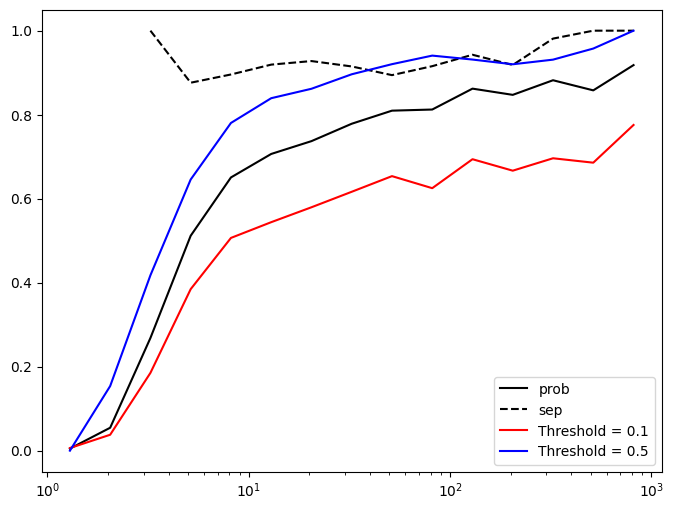

In [ ]:
snr_middle = snr_bins.mean(axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(snr_middle, precision_prob, '-k', label='prob')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, precision_sep, '--k', label='sep')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, thresh_out[0.1]['precision'], '-r', label='Threshold = 0.1')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, thresh_out[0.5]['precision'], '-b', label='Threshold = 0.5')
ax.set_xscale('log')
ax.legend()



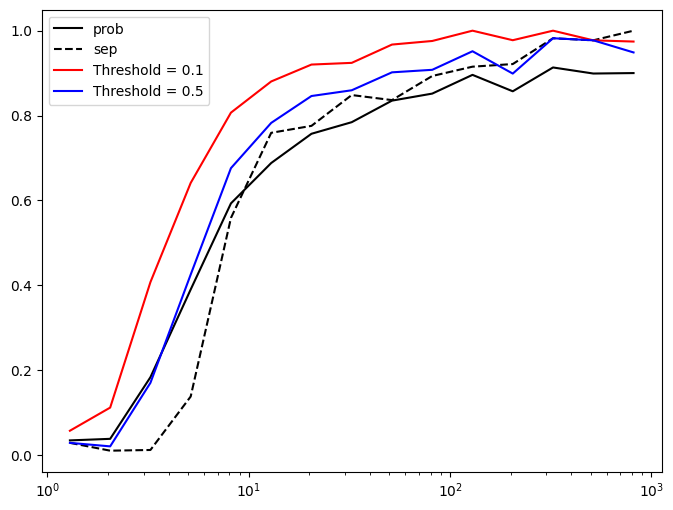

In [ ]:
snr_middle = snr_bins.mean(axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(snr_middle, recall_prob, '-k', label='prob')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, recall_sep, '--k', label='sep')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, thresh_out[0.1]['recall'], '-r', label='Threshold = 0.1')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, thresh_out[0.5]['recall'], '-b', label='Threshold = 0.5')
ax.set_xscale('log')
ax.legend()



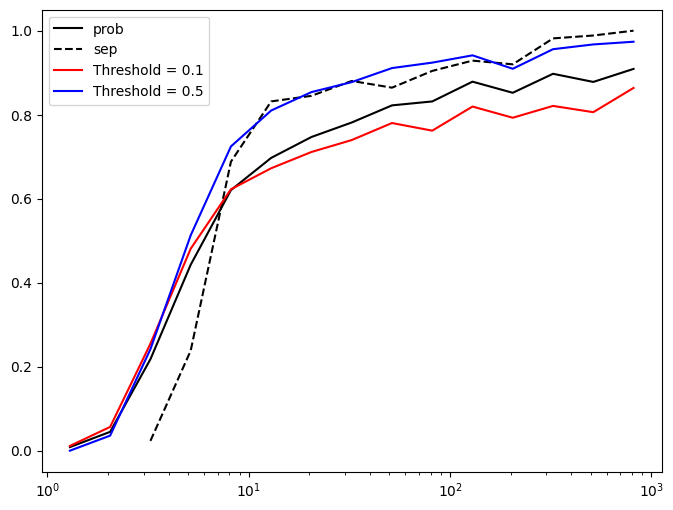

In [ ]:
snr_middle = snr_bins.mean(axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(snr_middle, f1_prob, '-k', label='prob')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, f1_sep, '--k', label='sep')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, thresh_out[0.1]['f1'], '-r', label='Threshold = 0.1')
ax.set_xscale('log')
ax.legend()

ax.plot(snr_middle, thresh_out[0.5]['f1'], '-b', label='Threshold = 0.5')
ax.set_xscale('log')
ax.legend()



## Efficiency matrix

In [ ]:
from bliss.reporting import compute_batch_tp_fp

def get_effmat(truth, cat):
    tp, _, n_true = compute_batch_tp_fp(truth, cat)

    mat = torch.zeros((tp.max().int().item()+1, n_true.max().int().item()+1))
    for ii in range(len(tp)):
        np = tp[ii].int().item()
        nt = n_true[ii].int().item()
        mat[np, nt] += 1
    return  mat / mat.sum(axis=0)

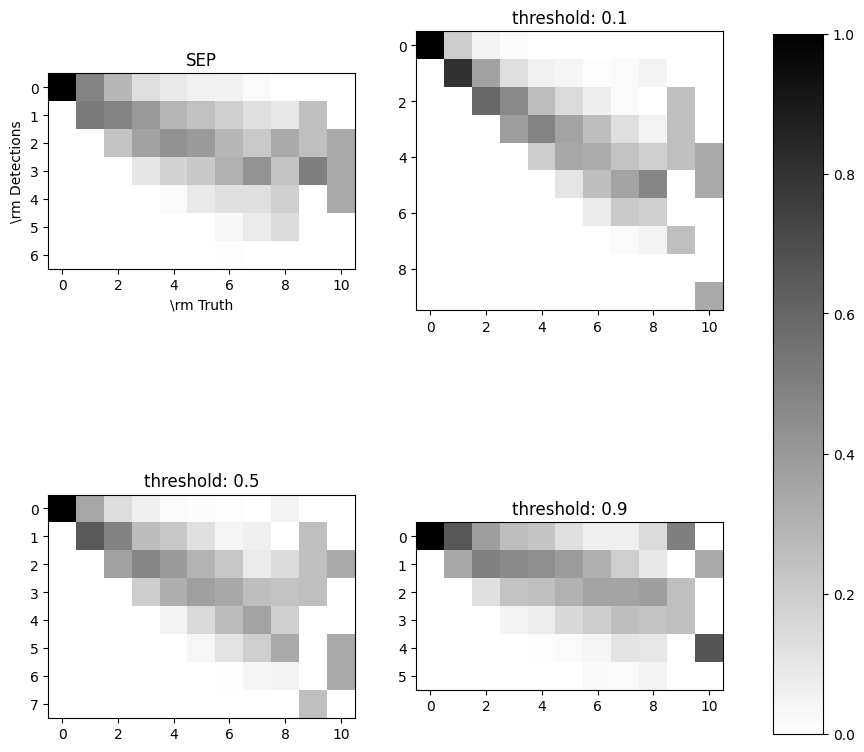

In [ ]:
# make matrix plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axes.ravel()

mat1 = get_effmat(truth, sep_cat)
im1 = ax1.imshow(mat1, vmin=0, vmax=1, cmap='binary')
ax1.set_ylabel(r"\rm Detections")
ax1.set_xlabel(r"\rm Truth")
ax1.set_title('SEP')

for tsh, ax in zip((0.1, 0.5, 0.9), (ax2, ax3, ax4)):

    mat = get_effmat(truth, pred_cats[tsh])
    im1 = ax.imshow(mat, vmin=0, vmax=1, cmap='binary')
    ax.set_title(f"threshold: {tsh}")

fig.subplots_adjust(right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

# titles
# ax.set_title(r"\rm Peak-Finding")
# ax2.set_title(r"\rm SEP")

# axes labels
# ax.set_ylabel(r"\rm Detections")



# plot 

# ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]);